In [2]:
import pandas as pd
import scipy
import re
import sys

import mongoTokens

In [3]:
data = pd.read_csv("../Dataset/final.csv")
target = data['label']
data.head()

,filter_str,denamed,queryLength,whereDetected,regexDetected,logicOperator,MathOperator,Size,thisPointer,matcherOption,cpuNanos,planningTimeMicros,label
0,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
1,"{'user': '{}', 'password': '{}'}","{'': '{}', '': '{}'}",32,0,0,0,0,0,0,0,176371,83.0,0.0
2,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
3,{'username': {'$regex': '^{}'}},{'': {'$regex': ''}},31,0,1,0,0,0,0,0,112781,71.0,1.0
4,{'username': {'$ne': '{}'}},{'': {'$ne': '{}'}},27,0,0,1,0,0,0,0,71093,42.0,1.0


In [4]:
boolColumns = data.select_dtypes(include=['int64','float64']).columns
for column in boolColumns:
    if set(data[column].unique()) == {0, 1}:
        data[column] = data[column].astype(bool)
data.dtypes

filter_str             object
denamed                object
queryLength             int64
whereDetected            bool
regexDetected            bool
logicOperator            bool
MathOperator             bool
Size                     bool
thisPointer              bool
matcherOption            bool
cpuNanos                int64
planningTimeMicros    float64
label                    bool
dtype: object

Significance Testing of Numerical Features

In [5]:
NumericalCols = data.select_dtypes(include=["float64","int64"]).columns
Numerics = data[NumericalCols]
Numerics.describe()


,queryLength,cpuNanos,planningTimeMicros
count,224.000000,224.000000,224.000000
mean,46.776786,99642.169643,63.125000
std,19.571971,44007.532865,46.788164
min,2.000000,49784.000000,27.000000
25%,33.000000,71093.000000,41.750000
50%,43.000000,88842.000000,55.500000
75%,58.000000,114685.250000,67.000000
max,105.000000,378420.000000,407.000000


In [6]:
NumericSamples = pd.concat([Numerics, target], axis=1)
NumericSamples.head()

,queryLength,cpuNanos,planningTimeMicros,label
0,32,176371,83.0,0.0
1,32,176371,83.0,0.0
2,31,112781,71.0,1.0
3,31,112781,71.0,1.0
4,27,71093,42.0,1.0


In [7]:
Sample0 = NumericSamples[NumericSamples['label'] == 0]
Sample1 = NumericSamples[NumericSamples['label'] == 1]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


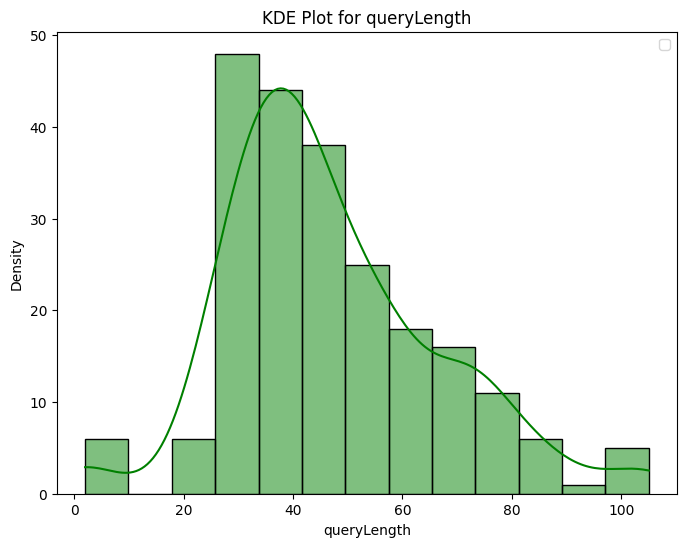

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


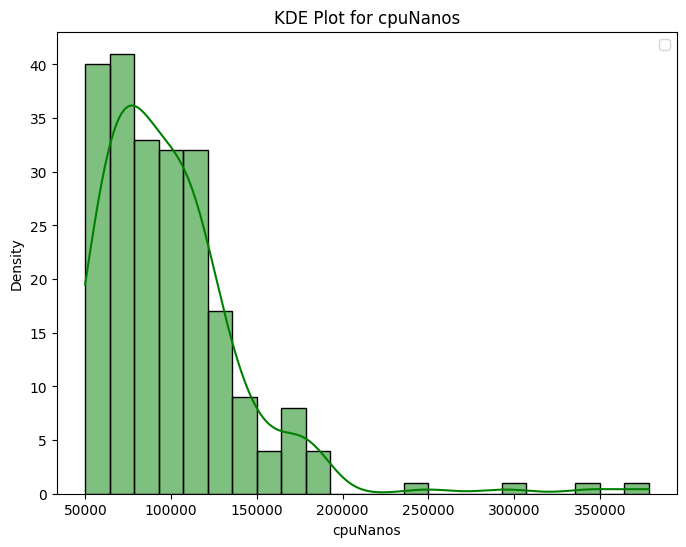

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


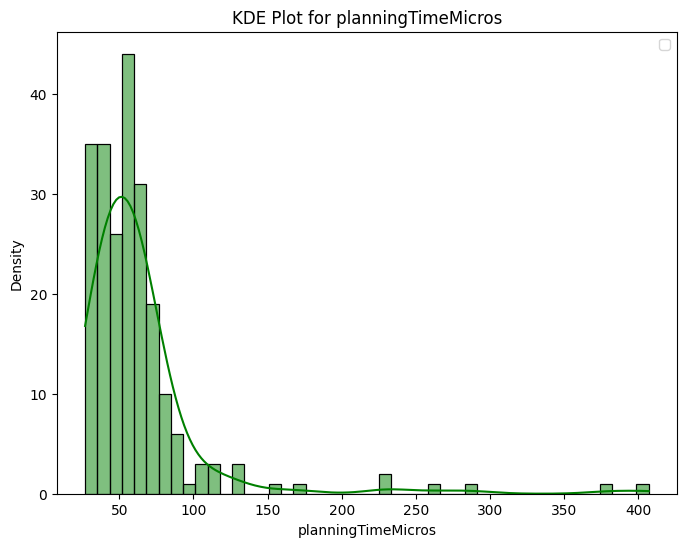

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


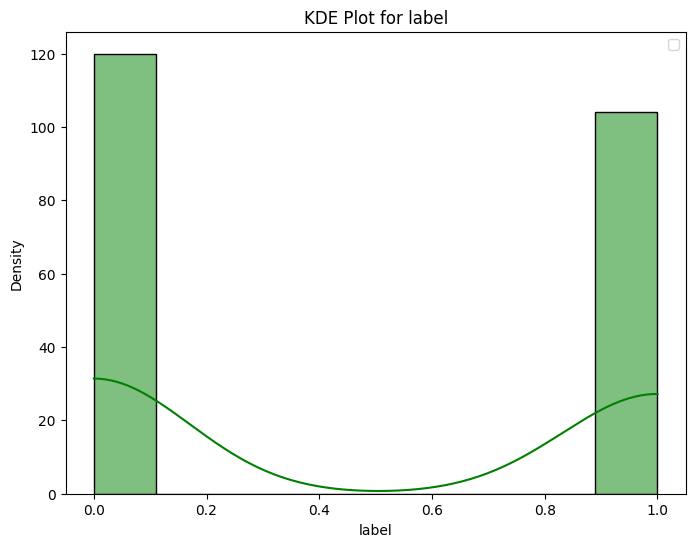

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in NumericSamples.columns:
    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    
    # Plot the KDE for Sample0
    sns.histplot(NumericSamples[col], color='green', fill=True, kde=True)
    
    # Add title and labels
    plt.title(f"KDE Plot for {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()

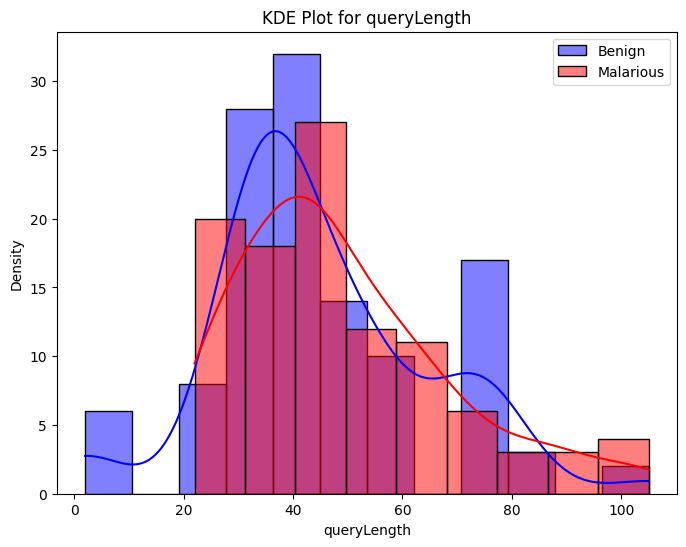

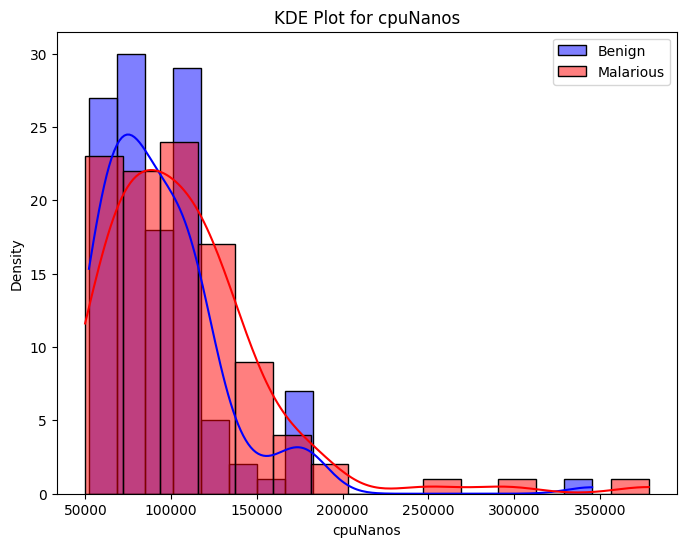

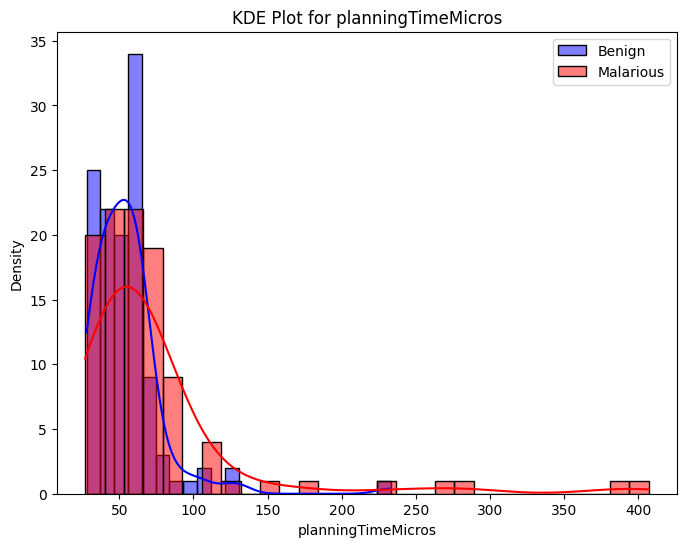

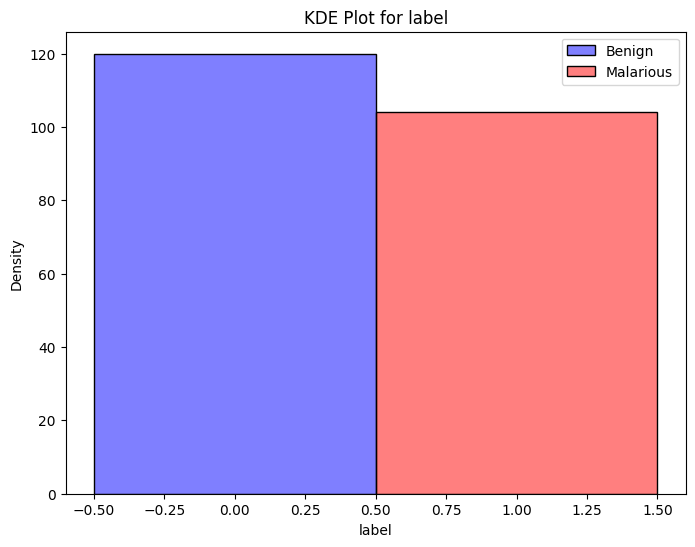

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Iterate over each column
for col in NumericSamples.columns:
    # Create a figure and axis
    plt.figure(figsize=(8, 6))
    
    # Plot the KDE for Sample0
    sns.histplot(Sample0[col], label='Benign', color='blue', fill=True, kde=True)
    
    # Plot the KDE for Sample1
    sns.histplot(Sample1[col], label='Malarious', color='red', fill=True, kde=True)
    
    # Add title and labels
    plt.title(f"KDE Plot for {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    
    # Show legend
    plt.legend()
    
    # Show the plot
    plt.show()


In [10]:
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu
results_dict = {}
for col in NumericalCols:
    Sample0 = NumericSamples[NumericSamples['label'] == 0][col]
    Sample1 = NumericSamples[NumericSamples['label'] == 1][col]
    
    # Perform KS test on each sample
    ks_statistic, ks_p_value = ks_2samp(Sample0, Sample1)
    _, ttest_p_value = ttest_ind(Sample0, Sample1)
    _, mannwhitney_p_value = mannwhitneyu(Sample0, Sample1, alternative='two-sided')
    
    results_dict[col] = {
        'KS p-value': ks_p_value,
        'KS Significance' : True if ks_p_value < 0.01 else False,
        'T-Test p-value': ttest_p_value,
        'T Significance' : True if ttest_p_value < 0.01 else False,
        'Mann-Whitney U p-value': mannwhitney_p_value,
        'Mann-Whitney Significance' : True if mannwhitney_p_value < 0.01 else False
    }


# Display the results DataFrame
pd.DataFrame(results_dict).transpose()

,KS p-value,KS Significance,T-Test p-value,T Significance,Mann-Whitney U p-value,Mann-Whitney Significance
queryLength,0.097899,False,0.132023,False,0.178336,False
cpuNanos,0.025985,False,0.024056,False,0.011228,False
planningTimeMicros,0.001472,True,0.002851,True,0.006628,True


In [11]:
HiddenCols = data.select_dtypes(include=["bool"]).columns
Hidden = data[HiddenCols]
Hidden.describe()

,whereDetected,regexDetected,logicOperator,MathOperator,Size,thisPointer,matcherOption,label
count,224,224,224,224,224,224,224,224
unique,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False
freq,220,183,141,212,208,220,219,120


/tmp/ipykernel_25735/1972535145.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col_name, data=Hidden, ax=ax, palette=colors, edgecolor='black', alpha = 0.7)
/tmp/ipykernel_25735/1972535145.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col_name, data=Hidden, ax=ax, palette=colors, edgecolor='black', alpha = 0.7)
/tmp/ipykernel_25735/1972535145.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col_name, data=Hidden, ax=ax, palette=colors, edgecolor='black', alpha = 0.7)
/tmp/ipykernel_25735/1972535145.py:19: FutureW

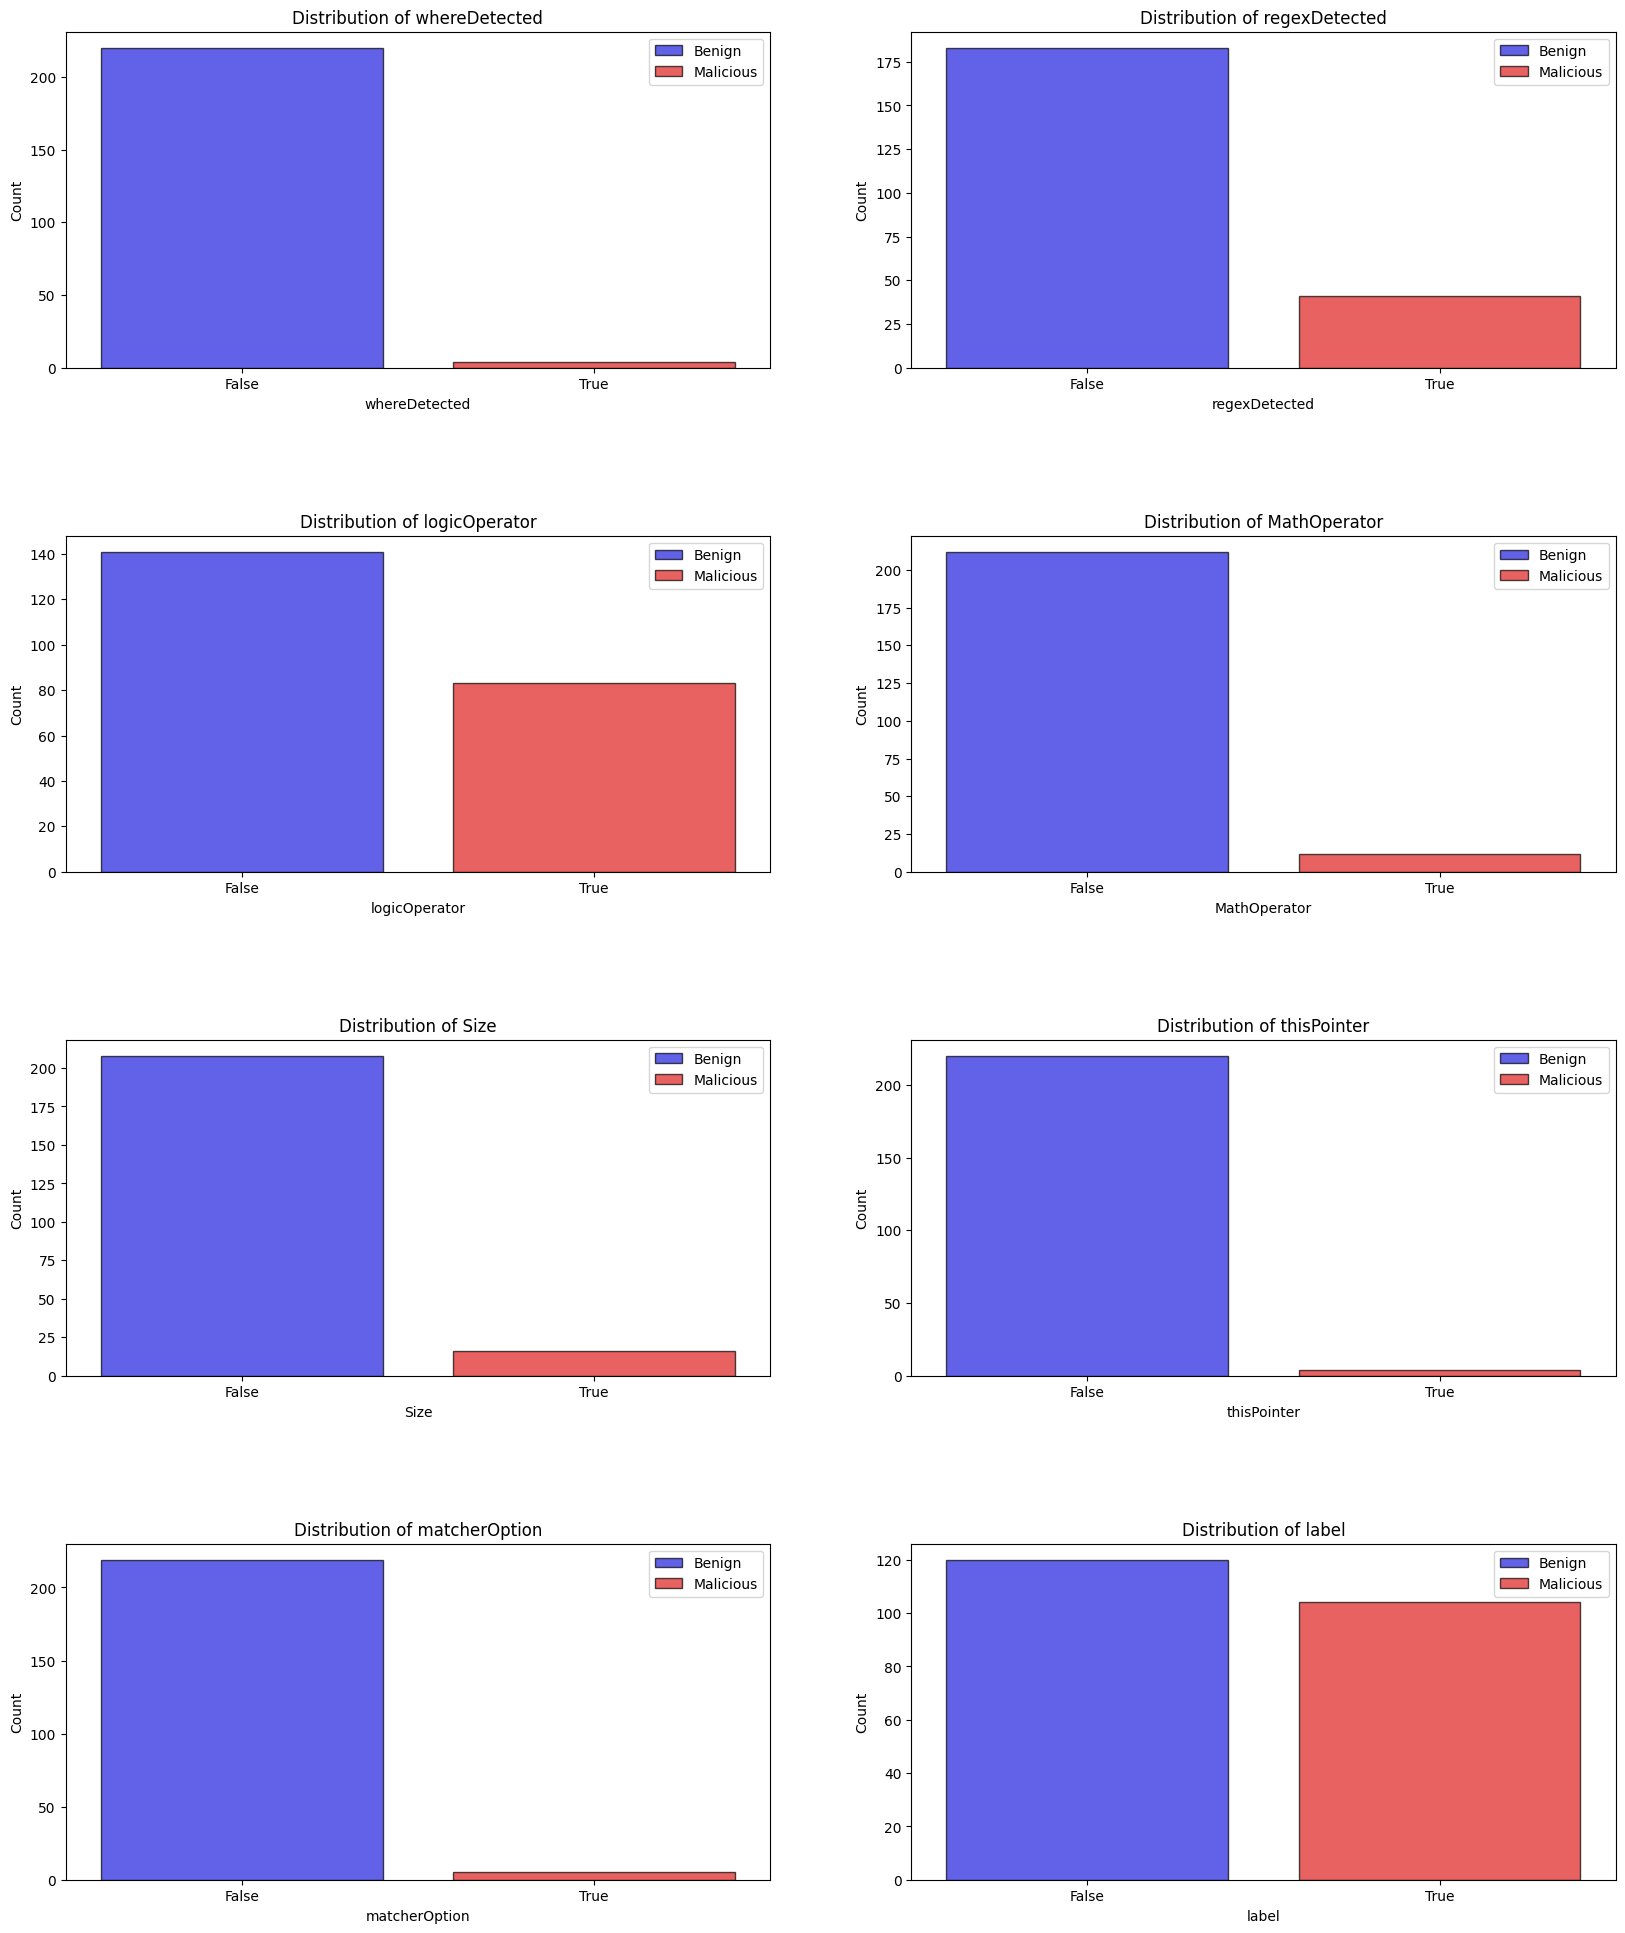

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define colors for 0 (benign) and 1 (malicious)
colors = ['blue', 'red']

# Calculate the number of rows and columns for the subplots
ncols = 2
nrows = 4

# Create a figure and subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 6 * nrows))

# Iterate over the columns and create a Bernoulli plot for each
for i, col_name in enumerate(Hidden.columns):
    row, col = i // ncols, i % ncols
    ax = axes[row, col] if nrows > 1 else axes[col]
    sns.countplot(x=col_name, data=Hidden, ax=ax, palette=colors, edgecolor='black', alpha = 0.7)
    ax.set_title(f'Distribution of {col_name}')
    ax.set_ylabel('Count')
    ax.legend(labels=['Benign', 'Malicious'])

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

In [36]:
Hidden.describe().transpose()

,count,unique,top,freq
whereDetected,224,2,False,220
regexDetected,224,2,False,183
logicOperator,224,2,False,141
MathOperator,224,2,False,212
Size,224,2,False,208
thisPointer,224,2,False,220
matcherOption,224,2,False,219
label,224,2,False,120


count    224.000000
mean       0.464286
std        0.499840
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: label, dtype: float64

In [47]:
from scipy.stats import chi2_contingency, fisher_exact

results_dict = {}

# Iterate over each column in 'Hidden'
for col in HiddenCols.drop('label'):
    # Create a contingency table for the Chi-square test
    contingency_table = pd.crosstab(Hidden[col], Hidden['label'])
    
    # Conduct Chi-square test
    chi2_stat, chi2_p_val, _, _ = chi2_contingency(contingency_table)
    
    # Conduct Fisher's exact test
    odds_ratio, fisher_p_val = fisher_exact(contingency_table)
    
    # Store the results in the dictionary
    results_dict[col] = {
        'Chi-square p-value': chi2_p_val,
        'Chi-Sq Significance' : True if chi2_p_val < 0.1 else False,
        'Fisher\'s exact p-value': fisher_p_val,
        'Fisher\'s Significance' : True if fisher_p_val < 0.1 else False,
    }

# Display the results dictionary
pd.DataFrame(results_dict).transpose()
pd.DataFrame(results_dict).transpose().to_csv('chisqFisher.csv')

In [41]:
target.astype('bool').describe()

count       224
unique        2
top       False
freq        120
Name: label, dtype: object

/tmp/ipykernel_25735/929511927.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_bool, ax=ax, palette=['blue', 'red'], alpha = 0.7, edgecolor='black')


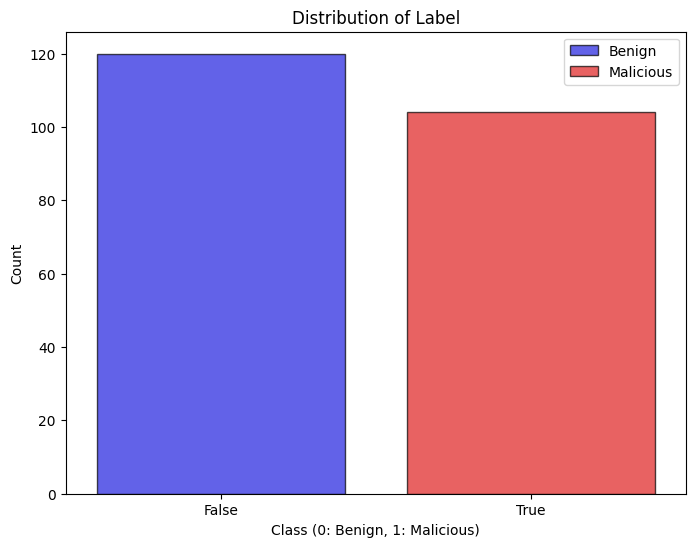

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the target column to boolean data type
target_bool = target.astype('bool')

# Create a Bernoulli plot for the target column
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x=target_bool, ax=ax, palette=['blue', 'red'], alpha = 0.7, edgecolor='black')
ax.set_title('Distribution of Label')
ax.set_xlabel('Class (0: Benign, 1: Malicious)')
ax.set_ylabel('Count')
ax.legend(labels=['Benign', 'Malicious'])

plt.show()